In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import datetime

In [2]:
data=pd.read_csv("./LGDisplay.csv")
data = data.sort_index(ascending=False)
data= data.reset_index()
data=data.drop(["index"], axis=1)

In [3]:
data

,날짜,종가,전일비,시가,고가,저가,거래량
0,2017.01.02,31150,300,31200,31300,30750,1158495
1,2017.01.03,31750,600,31300,31900,31250,1350385
2,2017.01.04,31450,300,31950,32250,31100,1297451
3,2017.01.05,31500,50,31550,31700,31100,1051313
4,2017.01.06,31650,150,31750,31950,31550,917903
...,...,...,...,...,...,...,...
1400,2022.09.14,15200,600,15350,15450,15200,919878
1401,2022.09.15,14950,250,15300,15500,14950,1182374
1402,2022.09.16,14500,450,14850,14950,14450,1766413
1403,2022.09.19,14300,200,14400,14500,14150,1212424


In [4]:
scaler=MinMaxScaler()
data['Close']=scaler.fit_transform(data['종가'].values.reshape(-1,1))
data = data['Close']

In [5]:
data

0       0.741667
1       0.761667
2       0.751667
3       0.753333
4       0.758333
          ...   
1400    0.210000
1401    0.201667
1402    0.186667
1403    0.180000
1404    0.181667
Name: Close, Length: 1405, dtype: float64

In [6]:
def make_dataset(data, window_size = 20):
    feature_list = []
    label_list = []
    for i in range(len(data)-window_size):
        feature_list.append(data.iloc[i:i+window_size])
        label_list.append(data.iloc[i+window_size])
    return np.array(feature_list), np.array(label_list)

data_X, data_Y = make_dataset(data)
train_data, train_label = data_X[:-200], data_Y[:-200]
test_data, test_label = data_X[-200:],data_Y[-200:]

In [7]:
X_train = torch.from_numpy(train_data).float()
y_train = torch.from_numpy(train_label).float()

X_test = torch.from_numpy(test_data).float()
y_test = torch.from_numpy(test_label).float()

In [8]:
X_train=X_train.view(X_train.shape[0],20,1)
y_train=y_train.view(-1,1)
X_test=X_test.view(X_test.shape[0],20,1)
y_test=y_test.view(-1,1)

In [9]:
X_train.shape

torch.Size([1185, 20, 1])

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM,self).__init__()
        
        self.hidden_dim=hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,x):
    
        h0=torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        
        c0=torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
    
        out, (hn, cn) =self.lstm(x, (h0,c0))
    
        
        out=self.fc(out[:,-1,:])
        
        return out
    

In [11]:
model=LSTM(input_dim=1, hidden_dim=50, output_dim=1, num_layers=2)
loss_fn=torch.nn.MSELoss(reduction='sum')
optimizer= torch.optim.Adam(model.parameters(),lr=0.01)

In [12]:
hist = np.zeros(200)    
    
for t in range(200):    
    
    # Forward pass
    
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

Epoch  10 MSE:  21.303394317626953
Epoch  20 MSE:  16.26215934753418
Epoch  30 MSE:  8.865410804748535
Epoch  40 MSE:  3.3544058799743652
Epoch  50 MSE:  2.209209442138672
Epoch  60 MSE:  1.5530633926391602
Epoch  70 MSE:  1.271999716758728
Epoch  80 MSE:  1.1037731170654297
Epoch  90 MSE:  0.9975361227989197
Epoch  100 MSE:  0.923724353313446
Epoch  110 MSE:  0.8670404553413391
Epoch  120 MSE:  0.8223494291305542
Epoch  130 MSE:  0.786078929901123
Epoch  140 MSE:  0.75467449426651
Epoch  150 MSE:  0.7273656129837036
Epoch  160 MSE:  0.7033243775367737
Epoch  170 MSE:  0.6818557977676392
Epoch  180 MSE:  0.6622810959815979
Epoch  190 MSE:  0.6439395546913147


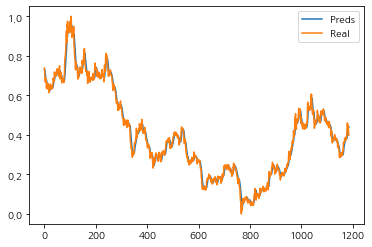

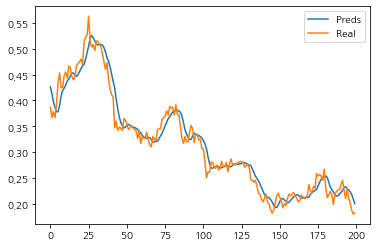

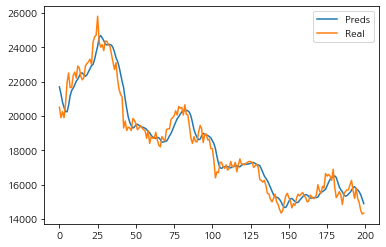

In [13]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Real")
plt.legend()
plt.show()

y_test_pred = model(X_test)
plt.plot(y_test_pred.detach().numpy(), label="Preds")
plt.plot(y_test.detach().numpy(), label="Real")
plt.legend()
plt.show()

y_test_pred=scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())
plt.plot(y_test_pred,label="Preds")
plt.plot(y_test, label="Real")
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

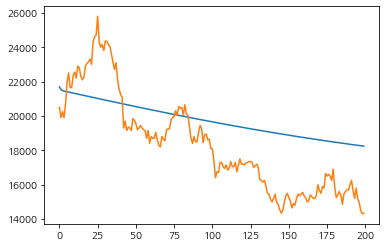

In [14]:
test_seq=X_test[:1]
preds=[]

for i in range(len(X_test)):
    y_test_pred=model(test_seq)
    
    pred=y_test_pred.item()
    preds.append(pred)

    new_seq=test_seq.numpy()
    
    new_seq=np.append(new_seq,pred)
    new_seq=new_seq[1:]
    test_seq=torch.from_numpy(new_seq).view(1,20,1).float()


preds=scaler.inverse_transform(np.array(preds).reshape(-1,1))
plt.plot(preds, label='Preds')
plt.plot(y_test, label='Data')
plt.show